In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

file_path = 'Dataset.xlsx'
df = pd.read_excel(file_path)

df_clean = df.dropna(subset=['DATE'])
df_clean['TIME'] = df_clean['TIME'].apply(lambda x: int(x.split('-')[0]))

label_encoder = LabelEncoder()
df_clean['SEASON'] = label_encoder.fit_transform(df_clean['SEASON'])

X = df_clean[['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)', 'TIME', '"WEEKEND/WEEKDAY"']]
y_season = df_clean['SEASON']
y_power = df_clean['POWER (KW)']

X_train_season, X_test_season, y_train_season, y_test_season = train_test_split(X, y_season, test_size=0.2, random_state=42)
X_train_power, X_test_power, y_train_power, y_test_power = train_test_split(X, y_power, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_season_scaled = scaler.fit_transform(X_train_season)
X_test_season_scaled = scaler.transform(X_test_season)
X_train_power_scaled = scaler.fit_transform(X_train_power)
X_test_power_scaled = scaler.transform(X_test_power)


<ipython-input-1-cf508fe21b2b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TIME'] = df_clean['TIME'].apply(lambda x: int(x.split('-')[0]))
<ipython-input-1-cf508fe21b2b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['SEASON'] = label_encoder.fit_transform(df_clean['SEASON'])


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

scaler = StandardScaler()
X_train_season_scaled = scaler.fit_transform(X_train_season)
X_test_season_scaled = scaler.transform(X_test_season)

model_season = Sequential([
    Input(shape=(X_train_season_scaled.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_season.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history_season = model_season.fit(
    X_train_season_scaled, y_train_season,
    epochs=100,
    validation_split=0.2,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)

test_loss_season, test_accuracy_season = model_season.evaluate(X_test_season_scaled, y_test_season, verbose=0)

y_pred_season = np.argmax(model_season.predict(X_test_season_scaled), axis=1)
y_pred_season_labels = label_encoder.inverse_transform(y_pred_season)
y_test_season_labels = label_encoder.inverse_transform(y_test_season)
target_names = [str(label) for label in label_encoder.classes_]

print("Season Prediction Classification Report:")
print(classification_report(y_test_season_labels, y_pred_season_labels, target_names=target_names))
print(f"Season Prediction Test Accuracy: {test_accuracy_season:.2f}")


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.3559 - loss: 1.0993 - val_accuracy: 0.7458 - val_loss: 0.9715
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5463 - loss: 0.9842 - val_accuracy: 0.8644 - val_loss: 0.8527
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6624 - loss: 0.8711 - val_accuracy: 0.9153 - val_loss: 0.7306
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7548 - loss: 0.7952 - val_accuracy: 0.8983 - val_loss: 0.6073
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7796 - loss: 0.6644 - val_accuracy: 0.9153 - val_loss: 0.4980
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8320 - loss: 0.6044 - val_accuracy: 0.9153 - val_loss: 0.4108
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8219 - loss: 0.5214 - val_accuracy: 0.9153 - val_loss: 0.3514
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8303 - loss: 0.4712 - val_accuracy: 0.9322 - val_loss

In [8]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

input_shape = (X_train_power_scaled.shape[1], 1)

model_cnn_power = Sequential([
    Input(shape=input_shape),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

model_cnn_power.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_cnn_power = model_cnn_power.fit(X_train_power_scaled[..., np.newaxis], y_train_power, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

test_loss_cnn_power, test_mae_cnn_power = model_cnn_power.evaluate(X_test_power_scaled[..., np.newaxis], y_test_power, verbose=0)
y_pred_cnn_power = model_cnn_power.predict(X_test_power_scaled[..., np.newaxis])

mae_cnn = mean_absolute_error(y_test_power, y_pred_cnn_power)
r2_cnn = r2_score(y_test_power, y_pred_cnn_power)
print(f"CNN Power Load Prediction Test MAE: {mae_cnn:.2f}")
print(f"CNN Power Load Prediction Test R2 Score: {r2_cnn:.2f}")


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 3042257.2500 - mae: 1615.6837 - val_loss: 3275304.2500 - val_mae: 1680.9896
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2948996.5000 - mae: 1585.9385 - val_loss: 3264865.0000 - val_mae: 1677.9158
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3203283.7500 - mae: 1652.2639 - val_loss: 3241638.5000 - val_mae: 1671.0773
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3050811.2500 - mae: 1610.8127 - val_loss: 3194806.2500 - val_mae: 1657.2247
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3121087.7500 - mae: 1623.2026 - val_loss: 3106872.7500 - val_mae: 1630.9504
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2771300.5000 - mae: 1522.6598 - val_loss: 2953543.0000 - val_mae: 1584.1560
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2968528.7500 - mae: 1574.4070 - val_loss: 2705397.7500 - val_mae: 1505.3267
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2330486.2500

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
CNN Power Load Prediction Test MAE: 259.32
CNN Power Load Prediction Test R2 Score: 0.79


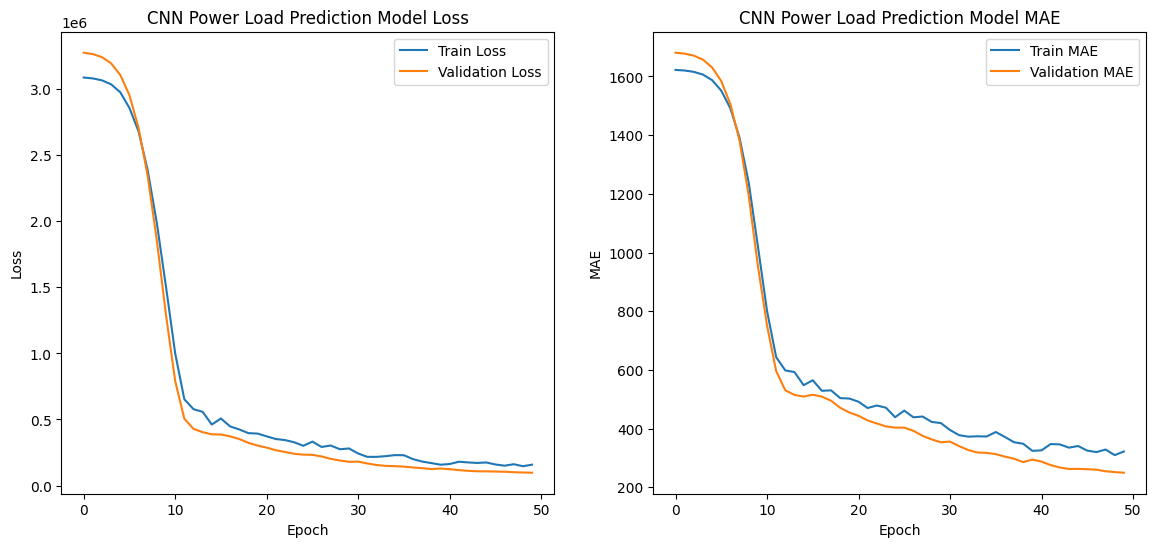

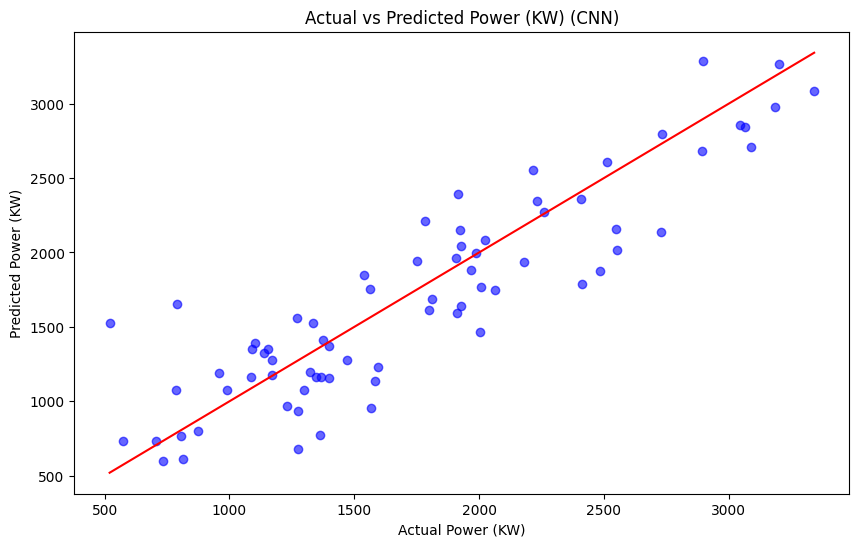

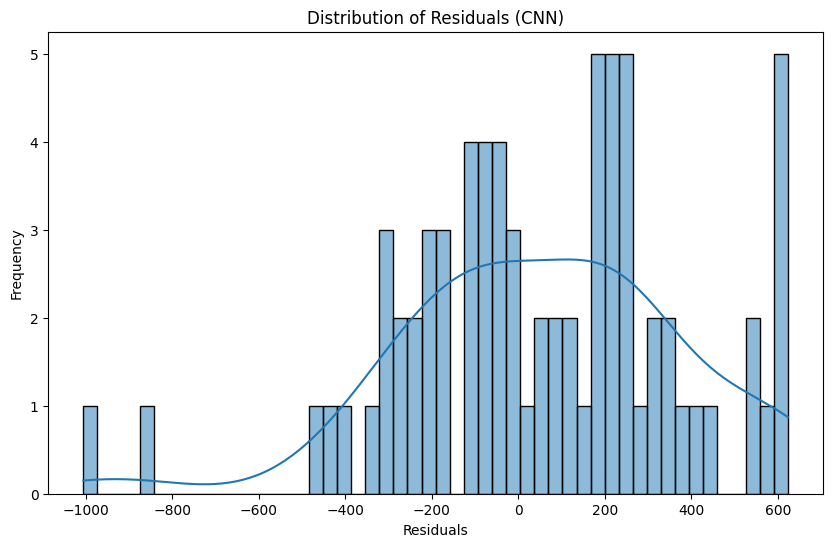

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_power.history['loss'], label='Train Loss')
plt.plot(history_cnn_power.history['val_loss'], label='Validation Loss')
plt.title('CNN Power Load Prediction Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_power.history['mae'], label='Train MAE')
plt.plot(history_cnn_power.history['val_mae'], label='Validation MAE')
plt.title('CNN Power Load Prediction Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_power, y_pred_cnn_power, alpha=0.6, color='b')
plt.title('Actual vs Predicted Power (KW) (CNN)')
plt.xlabel('Actual Power (KW)')
plt.ylabel('Predicted Power (KW)')
plt.plot([min(y_test_power), max(y_test_power)], [min(y_test_power), max(y_test_power)], color='red')
plt.show()

residuals_cnn = y_test_power - y_pred_cnn_power.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals_cnn, bins=50, kde=True)
plt.title('Distribution of Residuals (CNN)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


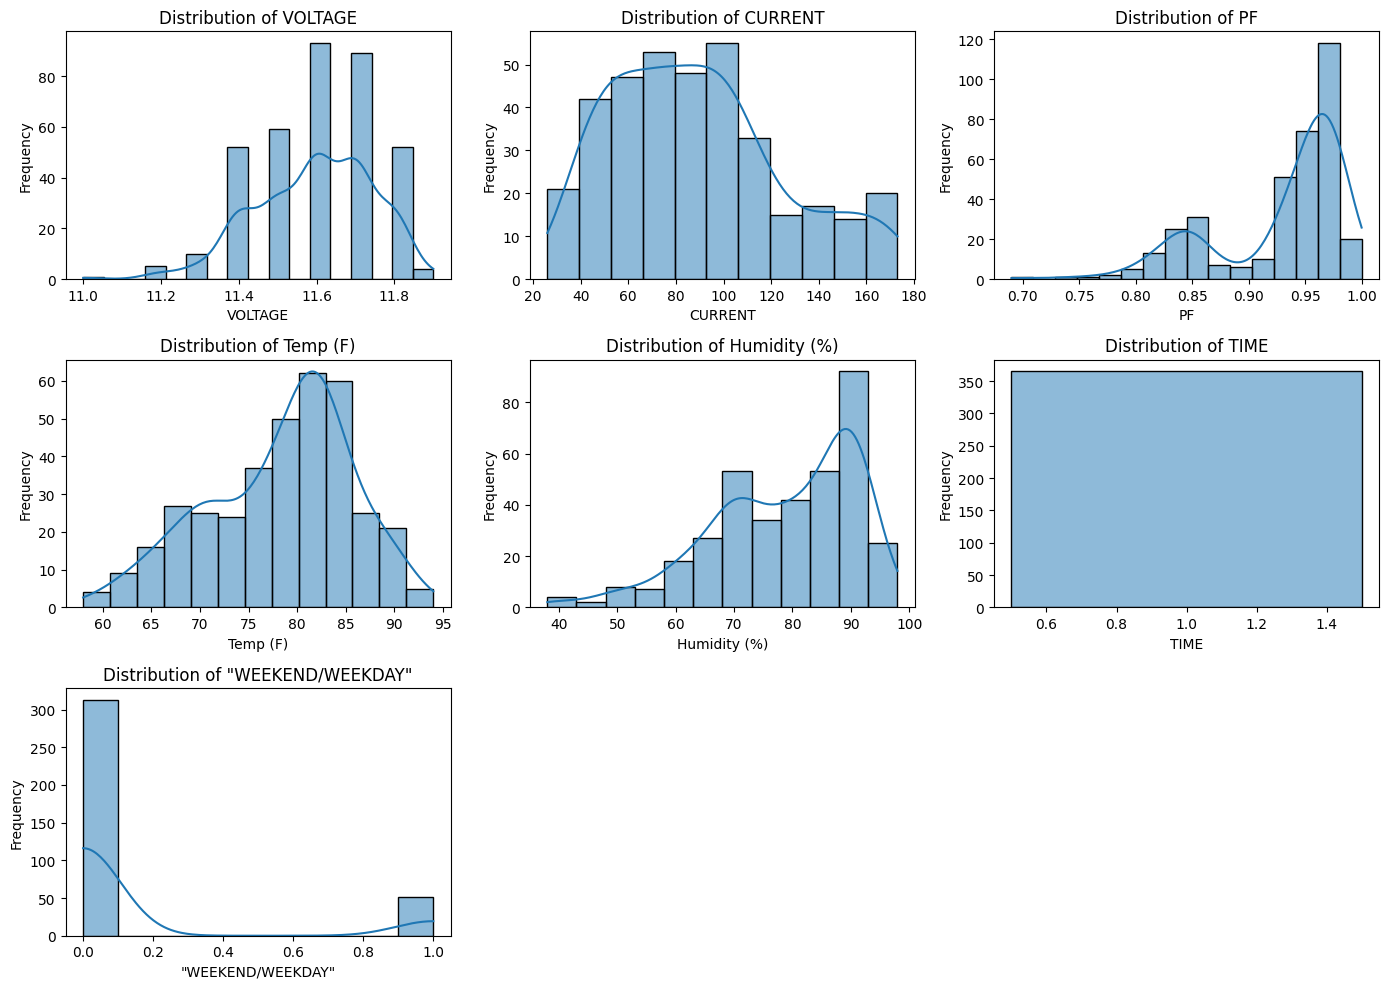

In [11]:
plt.figure(figsize=(14, 10))
for i, column in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_clean[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


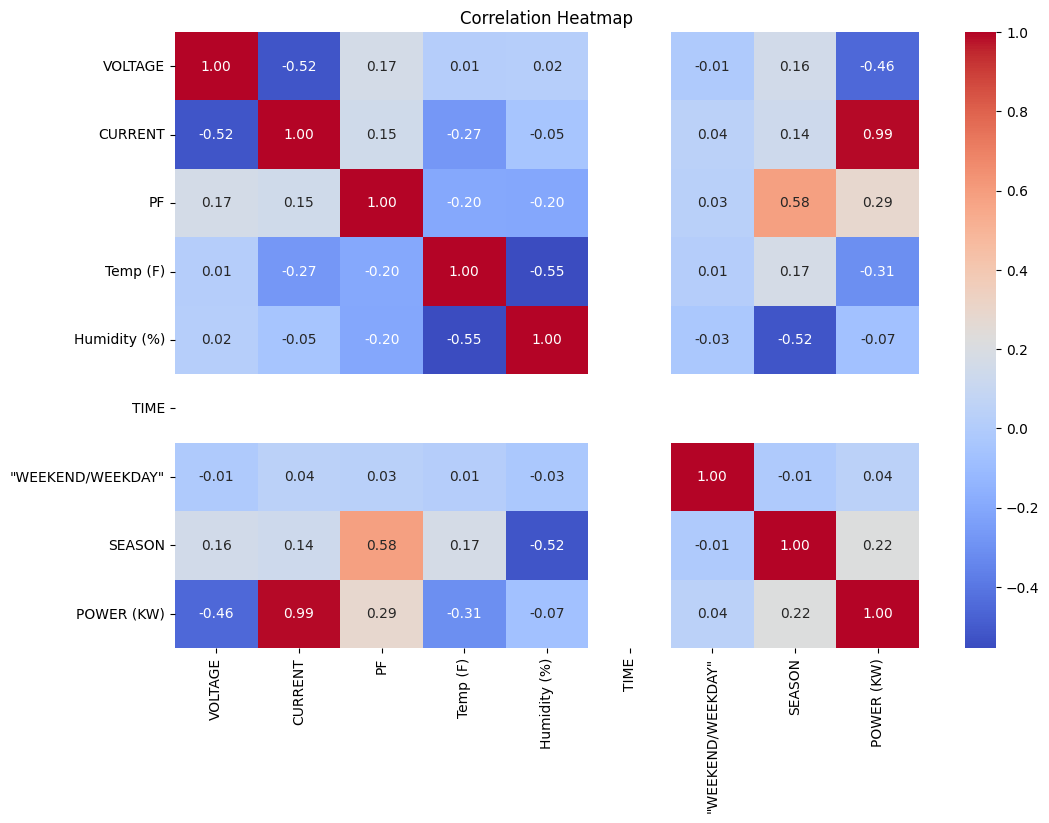

In [12]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)', 'TIME', '"WEEKEND/WEEKDAY"', 'SEASON', 'POWER (KW)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


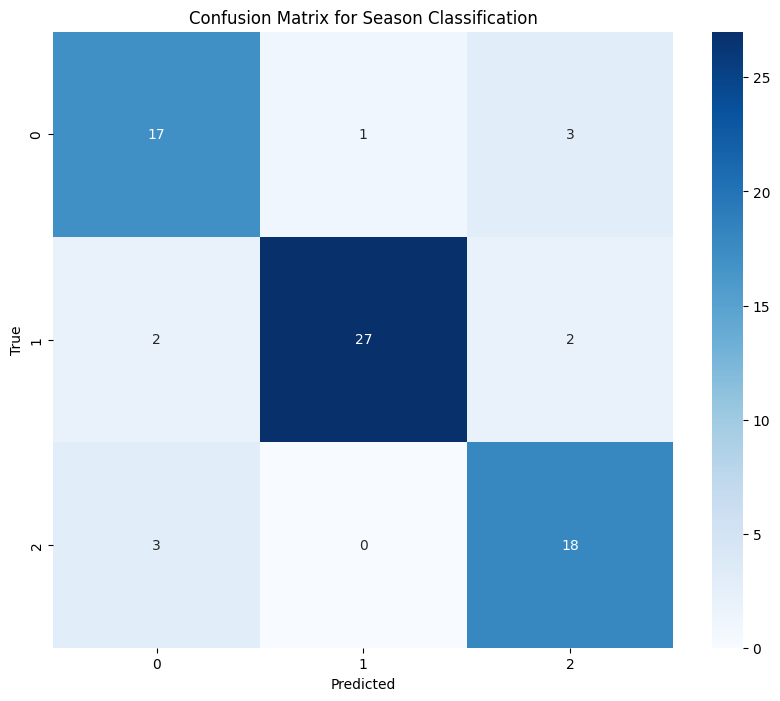

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix_season = confusion_matrix(y_test_season, y_pred_season)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_season, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Season Classification')
plt.show()


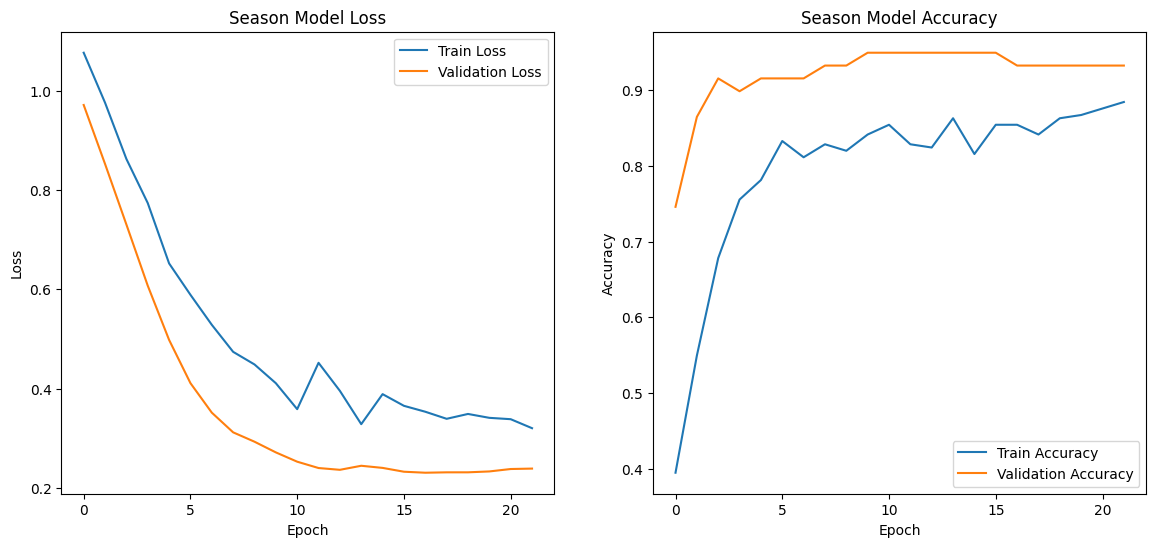

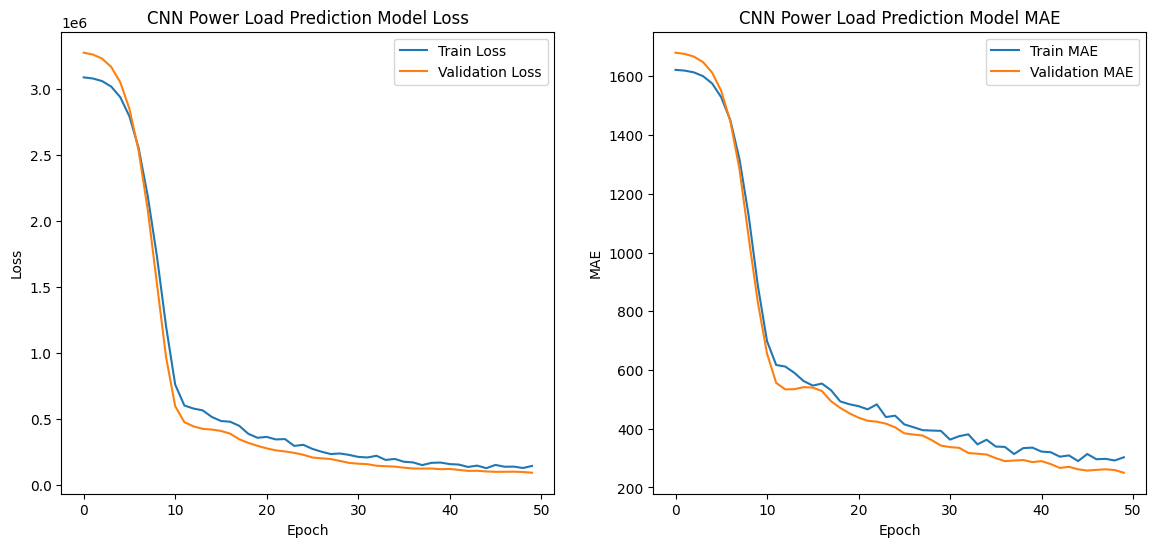

In [14]:
# Season Model Loss & Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_season.history['loss'], label='Train Loss')
plt.plot(history_season.history['val_loss'], label='Validation Loss')
plt.title('Season Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_season.history['accuracy'], label='Train Accuracy')
plt.plot(history_season.history['val_accuracy'], label='Validation Accuracy')
plt.title('Season Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# CNN Power Model Loss & MAE
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_power.history['loss'], label='Train Loss')
plt.plot(history_cnn_power.history['val_loss'], label='Validation Loss')
plt.title('CNN Power Load Prediction Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_power.history['mae'], label='Train MAE')
plt.plot(history_cnn_power.history['val_mae'], label='Validation MAE')
plt.title('CNN Power Load Prediction Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


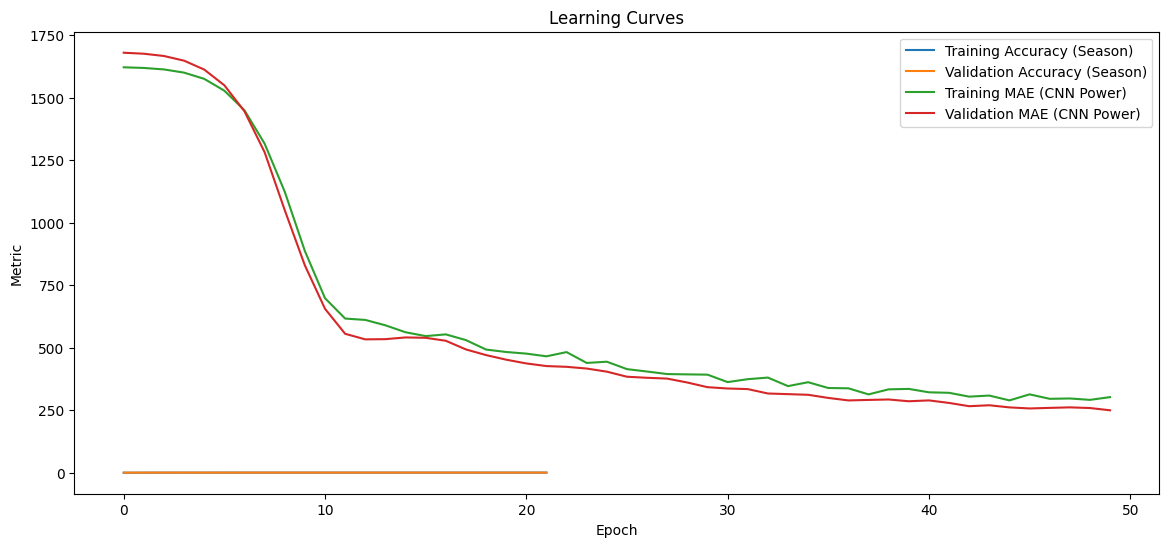

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(history_season.history['accuracy'], label='Training Accuracy (Season)')
plt.plot(history_season.history['val_accuracy'], label='Validation Accuracy (Season)')
plt.plot(history_cnn_power.history['mae'], label='Training MAE (CNN Power)')
plt.plot(history_cnn_power.history['val_mae'], label='Validation MAE (CNN Power)')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()


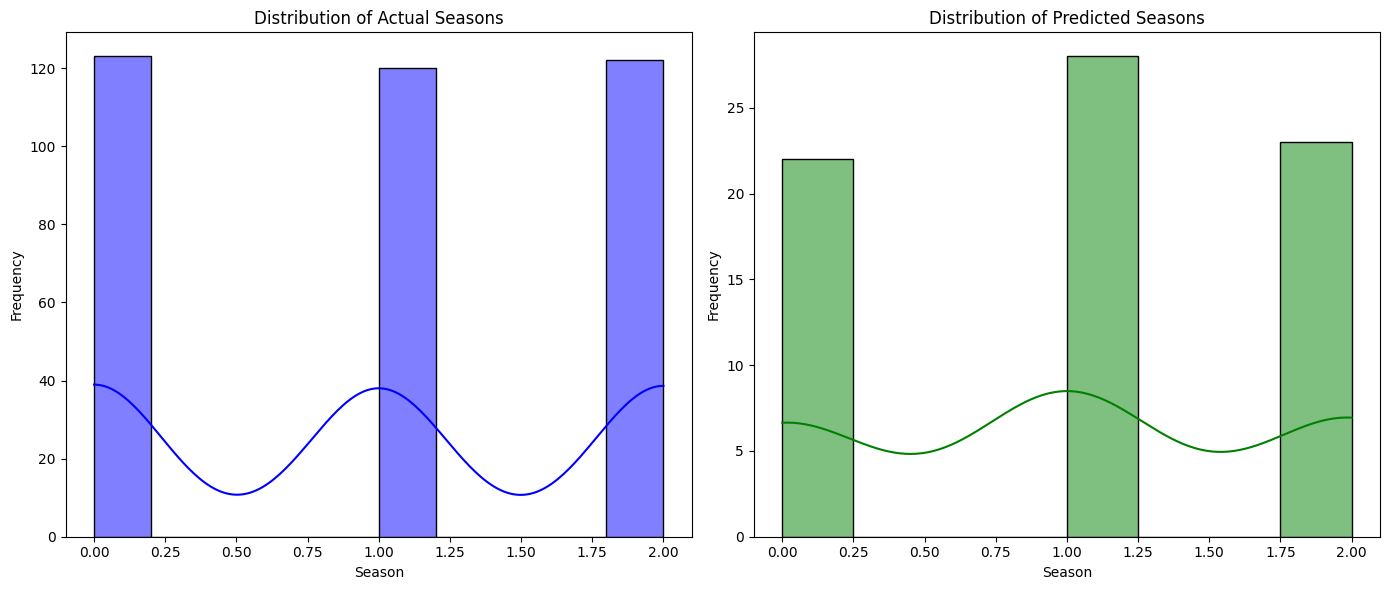

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_season, kde=True, color='blue', label='Actual Season')
plt.title('Distribution of Actual Seasons')
plt.xlabel('Season')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(y_pred_season, kde=True, color='green', label='Predicted Season')
plt.title('Distribution of Predicted Seasons')
plt.xlabel('Season')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


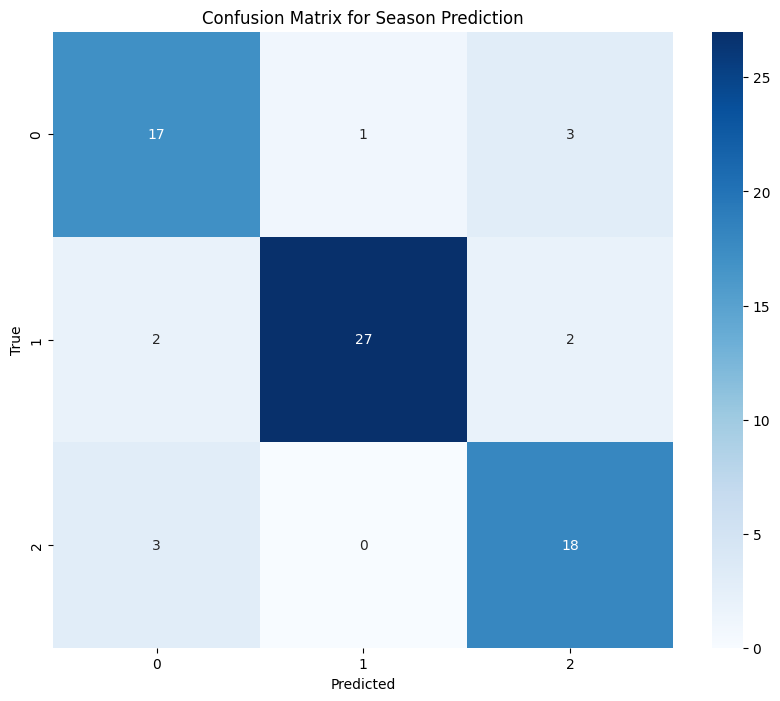

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix_season = confusion_matrix(y_test_season, y_pred_season)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_season, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Season Prediction')
plt.show()


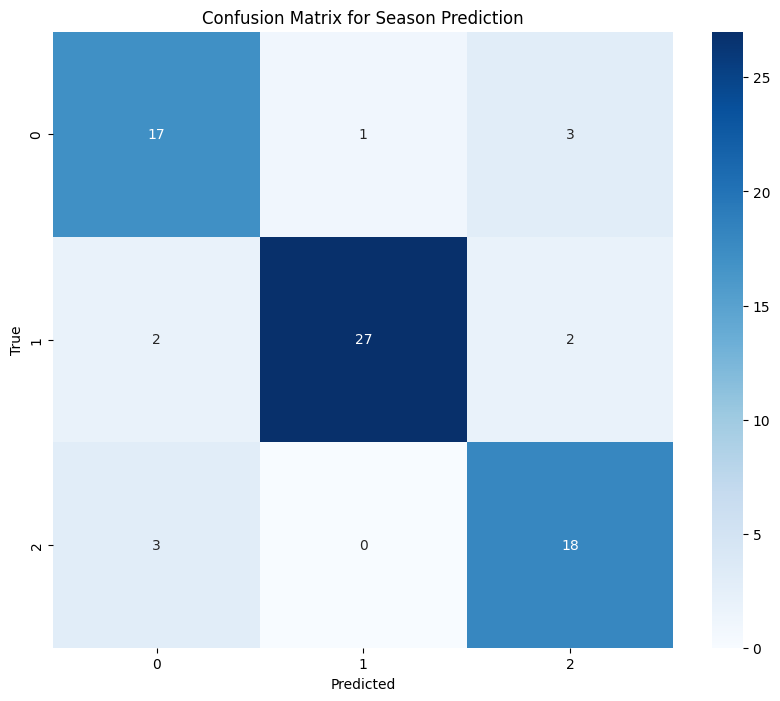

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix_season = confusion_matrix(y_test_season, y_pred_season)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_season, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Season Prediction')
plt.show()


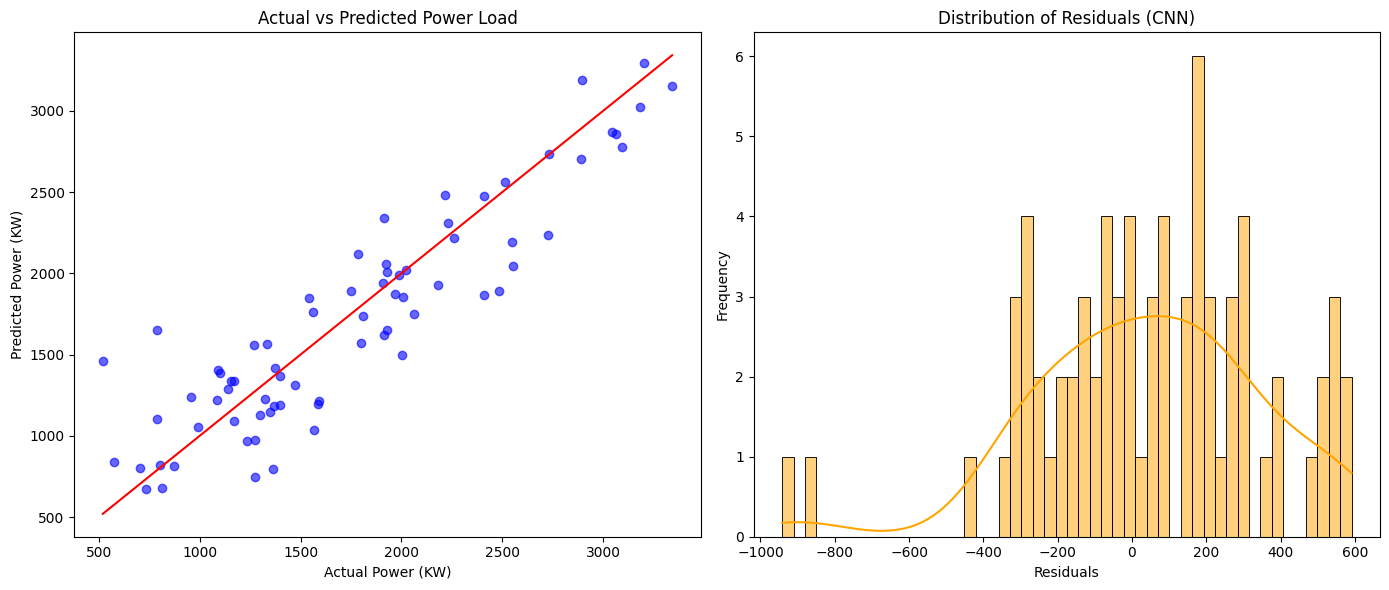

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_power, y_pred_cnn_power, alpha=0.6, color='blue')
plt.title('Actual vs Predicted Power Load')
plt.xlabel('Actual Power (KW)')
plt.ylabel('Predicted Power (KW)')
plt.plot([min(y_test_power), max(y_test_power)], [min(y_test_power), max(y_test_power)], color='red')

plt.subplot(1, 2, 2)
residuals_cnn = y_test_power - y_pred_cnn_power.flatten()
sns.histplot(residuals_cnn, bins=50, kde=True, color='orange')
plt.title('Distribution of Residuals (CNN)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


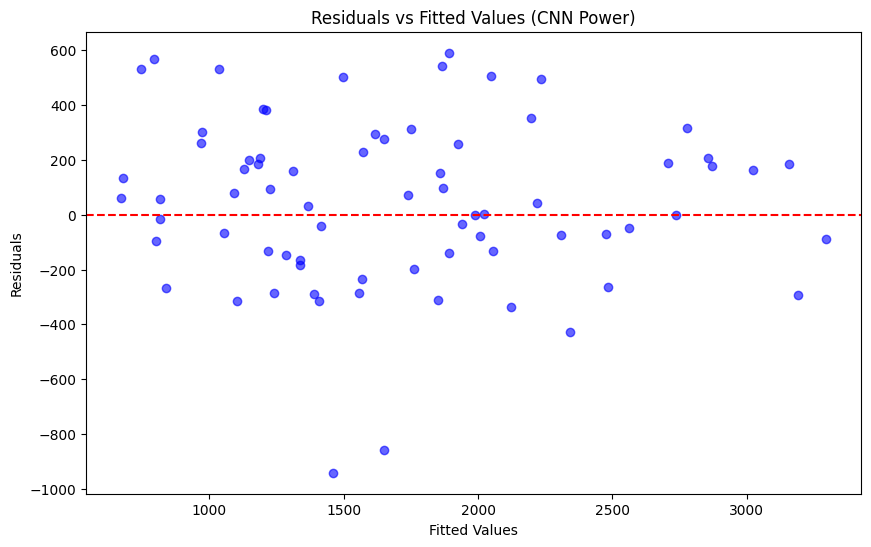

In [20]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(y_pred_cnn_power.flatten(), residuals_cnn, alpha=0.6, color='blue')
plt.title('Residuals vs Fitted Values (CNN Power)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()
